In [13]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Force reload of all modules to pick up environment variables
import sys

# Remove cached modules so they reload with correct env vars
modules_to_reload = [m for m in sys.modules.keys() if m.startswith('deep_research_from_scratch')]
for module_name in modules_to_reload:
    del sys.modules[module_name]

print(f"✓ Cleared {len(modules_to_reload)} cached modules")

✓ Cleared 7 cached modules


# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*

Here is our overall research flow:

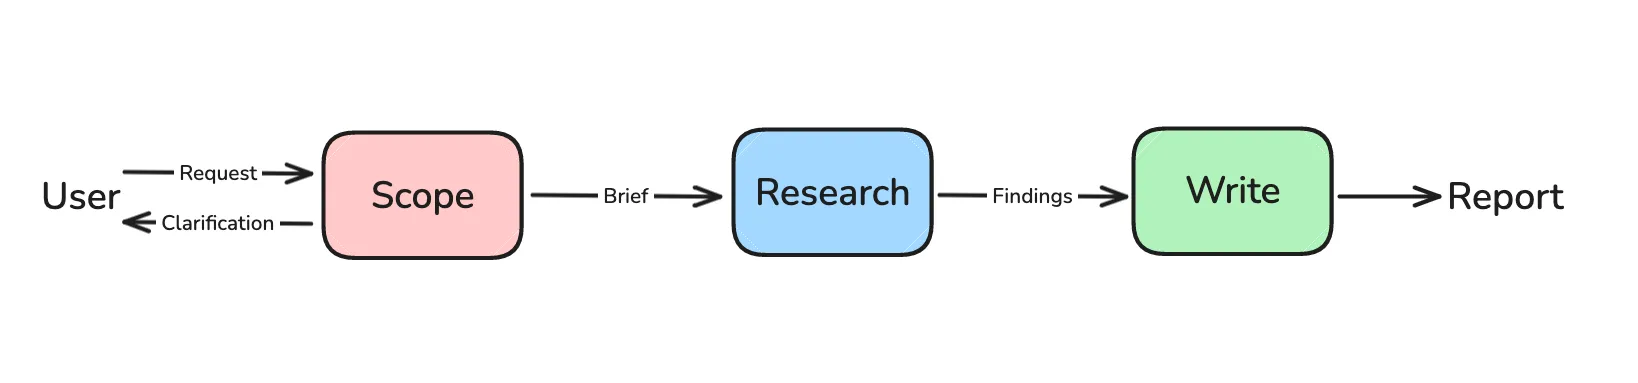

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? Single agent response quality *can* suffer with multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows. We'll build a system where a supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

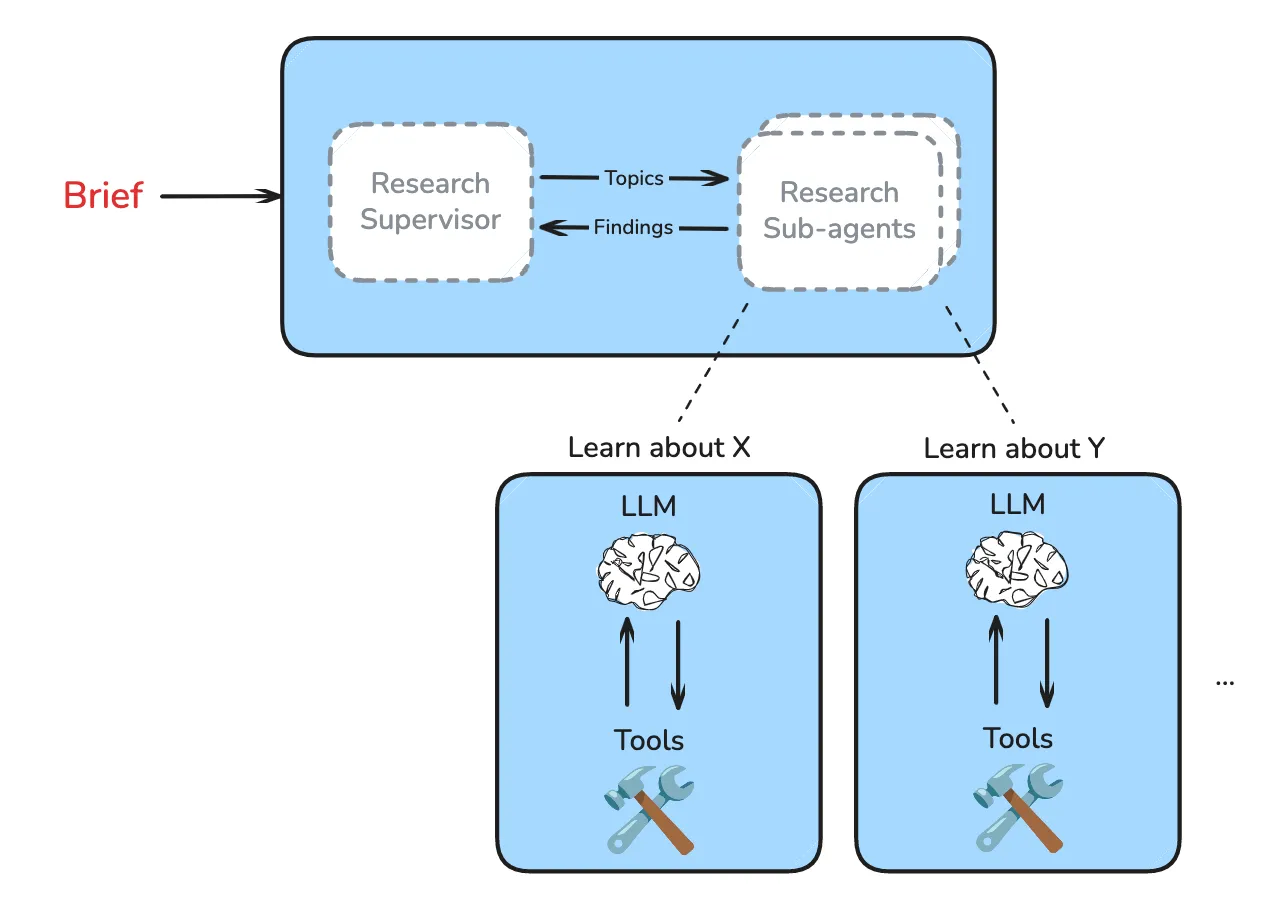

### Prompt

Now, let's design a prompt for the supervisor that follows the principles we've discussed, and include some insights from [the research literature](https://www.anthropic.com/engineering/built-multi-agent-research-system).

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the research. Are there multiple independent directions that can be explored simultaneously?
- **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still missing?

#### 2. Concrete Heuristics (For task delegation)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Bias towards single agent** - Use single agent for simplicity unless the user request has clear opportunity for parallelization. 
- **Stop when you can answer confidently** - Don't keep delegating research for perfection.
- **Limit tool calls** - Always stop after 3 tool calls to ConductResearch if you cannot find the right source(s).

#### 3. Show your thinking
Before you call ConductResearch tool call, use think_tool to plan your approach:
- Can the task be broken down into smaller sub-tasks?

After each ConductResearch tool call, use think_tool to analyze the results:
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### 4. Scaling rules
Simple fact-finding, lists, and rankings can use a single sub-agent.
- *Example*: List the top 10 coffee shops in San Francisco -> Use 1 sub-agent

Comparisons presented in the user request can use a sub-agent for each element of the comparison.
- *Example*: Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety -> Use 3 sub-agents.
- Delegate clear, distinct, non-overlapping subtopics

In [15]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

### State

The supervisor state manages the overall research coordination, while the researcher state handles individual research tasks.

In [16]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../src/deep_research_from_scratch/state_multi_agent_supervisor.py


### Multi-agent 

Now, we'll define our agent. A multi-agent system is a system that consists of multiple agents that work together to complete a task. The main benefit is context isolated, as discussed in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/). 

In [17]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# Ensure async compatibility for Jupyter environments
try:
    import nest_asyncio
    # Only apply if running in Jupyter/IPython environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Not in Jupyter, no need for nest_asyncio
except ImportError:
    pass  # nest_asyncio not available, proceed without it


# ===== CONFIGURATION =====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model(model="openai:gpt-4o")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 6 # Calls to think_tool + ConductResearch

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # Prepare system message with current date and constraints
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # Make decision about next research steps
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Initialize variables for single return pattern
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # Default next step
    should_end = False
    
    # Check exit criteria first
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        # Execute ALL tool calls before deciding next step
        try:
            # Separate think_tool calls from ConductResearch calls
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # Handle think_tool calls (synchronous)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # Handle ConductResearch calls (asynchronous)
            if conduct_research_calls:
                # Launch parallel research agents
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # Wait for all research to complete
                tool_results = await asyncio.gather(*coros)

                # Format research results as tool messages
                # Each sub-agent returns compressed research findings in result["compressed_research"]
                # We write this compressed research as the content of a ToolMessage, which allows
                # the supervisor to later retrieve these findings via get_notes_from_tool_calls()
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # Aggregate raw notes from all research
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    # Single return point with appropriate state updates
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== GRAPH CONSTRUCTION =====

# Build supervisor graph
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


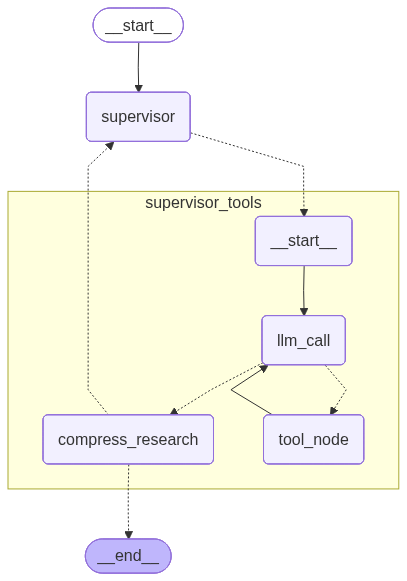

In [18]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# Show the agent
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [19]:
import os
print("✓ OPENAI_API_KEY:", "SET" if os.getenv('OPENAI_API_KEY') else "NOT SET")
print("✓ TAVILY_API_KEY:", "SET" if os.getenv('TAVILY_API_KEY') else "NOT SET")

# Test Tavily client initialization
try:
    from tavily import TavilyClient
    client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))
    print("✓ Tavily client initialized successfully")
except Exception as e:
    print(f"✗ Tavily client error: {e}")


✓ OPENAI_API_KEY: SET
✓ TAVILY_API_KEY: SET
✓ Tavily client initialized successfully


In [20]:
# Before running the supervisor, clear module cache to ensure fresh imports
import sys

# List of modules to clear
modules_to_clear = [
    'deep_research_from_scratch.multi_agent_supervisor',
    'deep_research_from_scratch.research_agent',
    'deep_research_from_scratch.utils',
    'deep_research_from_scratch.prompts',
    'deep_research_from_scratch.state_multi_agent_supervisor',
    'deep_research_from_scratch.state_research',
]

cleared = 0
for module_name in modules_to_clear:
    if module_name in sys.modules:
        del sys.modules[module_name]
        cleared += 1

print(f"✓ Cleared {cleared} cached modules")

# Now import fresh with the environment variables already set
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent
print("✓ Supervisor agent imported successfully with current environment variables")

✓ Cleared 6 cached modules
✓ Supervisor agent imported successfully with current environment variables


In [21]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to create a report on Wellington Management related to private markets. My research should focus on 
analyzing who are the key decision makers, what are the key products, the assets under management, current firms they are invested in (what they acquired),  
what are the sectors they are active in, what are the key competitors, what are the major recent news and announcements. Please provide the answers **ONLY**
based on information from their website (https://www.wellington.com/). The study should result in a well-supported report with the answers to the questions and citations.  
"""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to create a report on Wellington Management related to private markets. My research should focus on      │
│ analyzing who are the key decision makers, what are the key products, the assets under management, current      │
│ firms they are invested in (what they acquired),                                                                │
│ what are the sectors they are active in, what are the key competitors, what are the major recent news and       │
│ announcements. Please provide the answers **ONLY**                                                              │
│ based on information from their website (https://www.wellington.com/). The study should result in a             │
│ well-supported report with the answers to the questions and citations.                                          │
│ .                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The task requires collecting a comprehensive set of information about Wellington Management's  │
│ activities in private markets. This includes identifying key decision makers, key products, assets under        │
│ management, current firms they are invested in, active sectors, key competitors, and recent major               │
│ news.\n\nSince all this information is to be sourced from their website, the research can be broken down into   │
│ several sub-tasks:\n\n1. **Identify Key Decision Makers** - Look for executive team or leadership information   │
│ related to private markets on the website.\n2. **Key Products and Offerings in Private Markets** - Check the    │
│ sections related to products and strategies to understand their offerings.\n3. **Assets Under Management** -    │
│ Search for information related to the size of assets under management specifically in private markets.\n4.      │
│ **Current Firms and Acquisitions** - Investigate any partnerships, acquisitions, or investments listed on the   │
│ site.\n5. **Active Sectors** - Identify which sectors Wellington is most active in.\n6. **Competitors** - Look  │
│ for mentions of competitors in relevant sections, such as market analysis or investor insights.\n7. **Recent    │
│ News and Announcements** - Explore the news or press release section for recent updates and major               │
│ announcements. \n\nThese sub-topics are distinct enough to benefit from parallel research, saving time and      │
│ ensuring depth. I will proceed to set up parallel research tasks for these topics using the ConductResearch     │
│ tool."                                                                                                          │
│ }                                                                                                               │
│    ID: call_Irz565GhSr5Ko59pBEDuIZJy                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The task requires collecting a comprehensive set of information about Wellington           │
│ Management's activities in private markets. This includes identifying key decision makers, key products, assets │
│ under management, current firms they are invested in, active sectors, key competitors, and recent major news.   │
│                                                                                                                 │
│ Since all this information is to be sourced from their website, the research can be broken down into several    │
│ sub-tasks:                                                                                                      │
│                                                                                                                 │
│ 1. **Identify Key Decision Makers** - Look for executive team or leadership information related to private      │
│ markets on the website.                                                                                         │
│ 2. **Key Products and Offerings in Private Markets** - Check the sections related to products and strategies to │
│ understand their offerings.                                                                                     │
│ 3. **Assets Under Management** - Search for information related to the size of assets under management          │
│ specifically in private markets.                                                                                │
│ 4. **Current Firms and Acquisitions** - Investigate any partnerships, acquisitions, or investments listed on    │
│ the site.                                                                                                       │
│ 5. **Active Sectors** - Identify which sectors Wellington is most active in.                                    │
│ 6. **Competitors** - Look for mentions of competitors in relevant sections, such as market analysis or investor │
│ insights.                                                                                                       │
│ 7. **Recent News and Announcements** - Explore the news or press release section for recent updates and major   │
│ announcements.                                                                                                  │
│                                                                                                                 │
│ These sub-topics are distinct enough to benefit from parallel research, saving time and ensuring depth. I will  │
│ proceed to set up parallel research tasks for these topics using the ConductResearch tool.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify key decision makers at Wellington Management, specifically related to their       │
│ private markets division, using only information from their website."                                           │
│ }                                                                                                               │
│    ID: call_hAJGJaNztuTUgn9HIZ95lUqp                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Determine the key products and offerings in private markets by Wellington Management,      │
│ using only information from their website."                                                                     │
│ }                                                                                                               │
│    ID: call_LAalqAmVuVkm4sUZfEmh886V                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Find information about Wellington Management's assets under management in private markets, │
│ using only data from their website."                                                                            │
│ }                                                                                                               │
│    ID: call_zxfgUXD3NolGFJVYnhZnP5C3                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Searched for "Wellington Management private markets division key decision makers site:wellington.com".       │
│ 2. Searched for "site:wellington.com leadership team private markets division".                                 │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ - Wellington Management is a leading privately held asset management firm established in 1928, managing over    │
│ USD 1 trillion in client assets with more than 800 investment professionals serving 3,000+ clients across 60+   │
│ locations globally (figures as of June 2025). The firm emphasizes a long-term, research-driven investment       │
│ philosophy, leveraging a collaborative, integrated approach free from organizational silos. Wellington offers a │
│ diverse range of investment solutions including equity, fixed income, multi-asset, liquid alternatives and      │
│ hedge funds, private investing, and sustainable investing. The firm highlights its private ownership model,     │
│ collaborative culture, and integrated investment platform as competitive advantages. Through its nearly         │
│ 100-year history, the company has expanded globally and introduced innovative investment strategies, including  │
│ alternatives and private markets. Wellington prioritizes stewardship principles, corporate sustainability       │
│ efforts via its WellSustain program, and a commitment to diversity, equity, and inclusion. Client segments      │
│ served include central banks, sovereign institutions, defined benefit and contribution plans, endowments,       │
│ foundations, family offices, insurers, and intermediaries. The company maintains a global presence with offices │
│ in North America, Europe, and Asia-Pacific. “We’re different by design: As one of the world’s largest privately │
│ held asset managers, we are free to take the long view, innovate, and invest when others pull back. Our private │
│ ownership model enables us to focus on long-term success for clients. Our integrated boutique model connects    │
│ nearly 50 independent investment teams across all asset classes under a single management framework. Extensive  │
│ research and engagement practices are at the core of our sustainable investing platform, giving us a distinct   │
│ edge to help our clients reach their goals. At Wellington Management, we believe that a diverse workforce       │
│ thrives in an equitable and inclusive culture” [1], [2].                                                        │
│                                                                                                                 │
│ - On April 15, 2025, Wellington Management, Vanguard, and Blackstone announced a strategic alliance aimed at    │
│ transforming investor access to institutional-caliber investment opportunities. Their collaboration focuses on  │
│ developing simplified multi-asset investment solutions that integrate public and private markets, combining     │
│ active and index strategies. This initiative seeks to broaden access to complex multi-asset portfolios,         │
│ typically reserved for large global institutions, and support financial advisors in meeting clients’ income and │
│ growth objectives. The firms leverage their respective strengths: Wellington’s independent, multi-asset         │
│ investment platform managing over $1.3 trillion; Vangua

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - Queried: "site:wellington.com private markets products offerings"                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ Wellington Alternative Investments, a major independent asset manager based in the UK, manages $9.7 billion USD │
│ in assets under management (AUM) across 302 total investments, with an experienced team averaging over 16 years │
│ in the industry, focusing on nine key sectors. Their private investing platform integrates deep industry        │
│ research and expertise across public and private markets to invest in transformative private companies. The     │
│ platform specializes in venture capital segments including early-stage ventures, climate growth, late-stage     │
│ biotechnology, and late-stage growth companies, as well as private credit with investment-grade private         │
│ placements. Wellington collaborates with portfolio companies on Environmental, Social, and Governance (ESG)     │
│ initiatives, offering insights to support ESG improvements for better financial outcomes. They engage in        │
│ long-term climate research partnerships with the Woodwell Climate Research Center and MIT Joint Program on the  │
│ Science and Policy of Global Change to inform their climate investment strategies.                              │
│                                                                                                                 │
│ The private investing team features key leaders such as Michael Carmen, Shanna O'Reilly (Co-head of Private     │
│ Investments, recognized among GrowthCap's Top Women Leaders in Growth Investing), Michelle Hunter, Ravi Anand   │
│ (Head of Private Real Estate Credit), Emily Bannister (Director, Private Credit), Jackson Cummings, Jeff        │
│ Chapman, Laura Kirk, Nilesh Kumar, Emeka Onukwugha, Elisabeth Perenick, Greg Wasserman (Head of Private Climate │
│ Investing), and Matt Witheiler (Head of Late-Stage Growth, named on Forbes' Midas List multiple years). Recent  │
│ developments include the formation of a private real estate credit platform and the final close of their        │
│ inaugural Wellington CLO Partners Fund.                                                                         │
│                                                                                                                 │
│ Wellington provides extensive insights and thought leadership on private market topics such as public and       │
│ private market convergence, governance best practices for companies approaching IPOs, the impact of AI and      │
│ biotechnology in venture capital, and climate investing strategies. The firm emphasizes disciplined growth,     │
│ risk diversification, and innovation in its private investment approach. The content is aimed at professional   │
│ investors and intermediaries, guided by ESG stewardship principles and regulatory authorizations from the UK    │
│ Financial Conduct Authority. "Private investing takes Unique Perspectives. At Wellington, we consider the       │
│ private market from multiple angles." "We offer to work with our portfolio companies to support them as they    │
│ navigate the rapidly evolving ESG landscape." "Wellington Management welcomes Michael Trihy, CFA, as Head of    │
│ Portfolio Management, Venture Growth Evergreen, Private

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - Query: "Wellington Management assets under management private markets site:wellington.com"                    │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ Wellington Management is one of the world’s largest privately held asset managers, managing over USD 1 trillion │
│ in client assets across more than 60 global locations as of June 2025. Founded in 1928, the firm emphasizes     │
│ long-term, research-driven investment approaches across major asset classes including equity, fixed income,     │
│ multi-asset, liquid alternatives, hedge funds, private investing, and sustainable investing. Wellington         │
│ operates with a unique private ownership model, fostering independence, collaboration, and integration among    │
│ over 800 investment professionals and nearly 50 independent investment teams. Their capabilities include        │
│ portfolio management, global research, investment strategy, data science (Investment Science Team), risk        │
│ management, and global trading with over US$13 trillion in annual trading volume. Wellington serves diverse     │
│ clients, such as central banks, sovereign institutions, defined benefit and contribution plans, endowments,     │
│ foundations, family offices, insurers, consultants, and wealth managers. The firm's culture promotes diversity, │
│ equity, inclusion, and sustainability through initiatives like the WellSustain program, which focuses on        │
│ operational stewardship, people empowerment, and community support. Wellington’s history highlights major       │
│ milestones including the founding of the Wellington Fund in 1928, going private in the 1960s, global expansion  │
│ with offices in London, Asia-Pacific, Hong Kong, Shanghai, Frankfurt, Luxembourg, and Zurich, and developing a  │
│ robust alternatives platform. Their mission is to achieve investment excellence for clients while impacting     │
│ lives positively worldwide [1].                                                                                 │
│                                                                                                                 │
│ On October 13, 2025, Wellington Management, a leading independent investment firm with over US$1.3 trillion in  │
│ assets under management, appointed Michael Trihy, CFA, as Head of Portfolio Management for Venture Growth       │
│ Evergreen within its Private Investments platform. In this role, Trihy will spearhead the expansion of          │
│ Wellington’s evergreen private investing capabilities aimed at private wealth clients, overseeing portfolio     │
│ construction and capital allocation across direct growth and venture investments, secondaries, and select fund  │
│ investments. Wellington's Private Investing platform currently manages over US$9.7 billion globally, with 302   │
│ investments spanning venture capital, private credit, and private real estate across nine sectors. Trihy brings │
│ 15 years of experience from roles at Bow River Capital, Partners Group, Red Rocks Capital, and FirstBank.       │
│ Michelle L. Hunter, Director of Private Investments at Wellington, highlighted Trihy’s expertise in private     │
│ wealth channels as pivotal amid growing demand for private market access and evergreen funds. Trihy emphasized  │
│ the under-allocation of private wealth investors to pri

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Identify the sectors Wellington Management is most active in, specifically through their   │
│ private markets division, using only information from their website."                                           │
│ }                                                                                                               │
│    ID: call_5IKjaafC6eBijEC3RuZ4F3hd                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Find information about key competitors of Wellington Management in private markets, using  │
│ only data available on their website."                                                                          │
│ }                                                                                                               │
│    ID: call_A3Bto1LLTloFmBmM8VrNitiI                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Explore the recent news and major announcements related to Wellington Management's private │
│ markets division, using only their website as a source."                                                        │
│ }                                                                                                               │
│    ID: call_dUPVYHX456M12qv2uf32oy7D                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Query: "Wellington Management private markets division sectors site:wellington.com"                          │
│ 2. Query: "Wellington Management private markets focus sectors"                                                 │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ Wellington Management Company LLP is one of the world's largest privately held asset managers, managing over    │
│ USD 1 trillion in client assets as of June 2025. Founded in 1928, Wellington offers a diversified range of      │
│ investment solutions spanning equity, fixed income, multi-asset, liquid alternatives and hedge funds, private   │
│ investing, and sustainable investing. Wellington Management’s integrated platform includes research, portfolio  │
│ management, trading, data science, risk management, and investment strategy. Their clients include central      │
│ banks, sovereign institutions, consultants, defined benefit and contribution plans, endowments, family offices, │
│ insurers, and wealth managers. The firm has a collaborative culture with an emphasis on diversity, equity,      │
│ inclusion, and corporate sustainability through initiatives like WellSustain. Wellington has expanded globally  │
│ with offices in major financial centers worldwide and has a long-term focus on innovation, client service, and  │
│ stable growth. [[1]](https://www.wellington.com/en/about-us/learn-more-about-our-firm)                          │
│                                                                                                                 │
│ Wellington Management offers investment solutions across asset classes including fixed income, alternatives,    │
│ private investing, and sustainable investing. As of June 2025, Wellington manages over USD 1 trillion in client │
│ assets, serves more than 3,000 clients, and employs over 800 investment professionals across 60+ countries. The │
│ firm highlights the depth and continuity of talent stemming from its unique ownership model. The firm was named │
│ "Insurance Asset Manager of the Year" ($100 billion+ in Insurance AUM category) in 2024 by Insurance Investor.  │
│ [[2]](https://www.wellington.com/en)                                                                            │
│                                                                                                                 │
│ On April 15, 2025, Wellington Management, Vanguard, and Blackstone announced a strategic alliance aiming to     │
│ develop simplified multi-asset investment solutions integrating public and private markets, as well as active   │
│ and index strategies. The collaboration seeks to democratize access to diversified portfolios that include      │
│ private assets, with emphasis on supporting financial advisors in income and growth objectives. Jean M. Hynes,  │
│ CEO, Wellington Management, stated: "Vanguard and Wellington have worked closely together for 50 years and have │
│ long admired Blackstone's capabilities. We believe the unique combination of our investment expertise and       │
│ well-respected brands will enable us to provide investo

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Queried: “Wellington Management competitors private markets”                                                 │
│ 2. Queried: “WorldQuant private markets strategy”                                                               │
│ 3. Queried: “Insight Partners private market investments”                                                       │
│ 4. Queried: “Vista Equity Partners private equity market”                                                       │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ Wellington Management's competitors and similar companies include WorldQuant, Insight Partners, Vista Equity    │
│ Partners, and Antler. [1]                                                                                       │
│                                                                                                                 │
│ Wellington is an independent asset management firm headquartered in Boston, United States, founded in 1928 by   │
│ Walter Leslie Morgan. The company offers diverse investment solutions across asset classes such as equity,      │
│ fixed income, multi-asset, alternatives, and private investing, with a focus on sustainable investing and       │
│ stewardship principles. As of December 31, 2022, Wellington employs approximately 1,860 people, reflecting a 6% │
│ growth from the previous year. It ranks 85th among 12,093 active competitors in the asset management sector     │
│ including major firms like Fidelity Investments, Investec, and Royal Bank of Canada. [2]                        │
│                                                                                                                 │
│ Blackstone, Vanguard, and Wellington have released additional information regarding their private markets fund. │
│ [3]                                                                                                             │
│                                                                                                                 │
│ WorldQuant:                                                                                                     │
│ WorldQuant, LLC is a private American hedge fund and quantitative investment management firm founded in 2007 by │
│ Belarus-born Igor Tulchinsky. Headquartered in Old Greenwich, Connecticut, it operates globally with over 20    │
│ offices and around 1,000 employees as of 2023. The firm manages approximately $9 billion in assets on behalf of │
│ Millennium Management, utilizing quantitative trading strategies heavily reliant on data mining, artificial     │
│ intelligence, and statistical arbitrage. WorldQuant originated as a spin-off from Millennium Management,        │
│ retaining key talent and infrastructure. Over time, it developed a large 'Alpha Factory' repository of around   │
│ four million predictive trading algorithms ('alphas') supported by a WebSim platform that engages thousands of  │
│ research consultants worldwide. The company has launched initiatives such as the WorldQuant Challenge and       │
│ WorldQuant Accelerator (now inactive) to crowdsource tr

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - Searched for “Wellington Management private markets recent news site:wellington.com”                          │
│ - Reviewed relevant Wellington Management news pages for updates and announcements related to the private       │
│ markets division                                                                                                │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ - The webpage presents comprehensive information and recent news concerning Wellington Management Company LLP,  │
│ a global investment management firm. It details their funds, especially the Wellington Global Multi-Strategy    │
│ Fund, and offers insights into investment outlooks, capabilities, and client services. Significant recent       │
│ developments include leadership changes such as the retirement of the President, Managing Partner and Head of   │
│ the Client Platform, with Samantha Schoen named as successor. The firm has expanded its private investment and  │
│ alternative capabilities, including launching a private real estate credit platform and interval fund for U.S.  │
│ wealth investors. Wellington has engaged in strategic collaborations with major firms like Vanguard and         │
│ Blackstone to offer integrated public and private market investment solutions. It has received multiple         │
│ prestigious industry awards in 2024 and 2025, including 'Structured Debt Manager of the Year,' 'Multi-Asset     │
│ Manager of the Year,' and 'Insurance Asset Manager of the Year.' Key personnel such as Matt Witheiler and       │
│ Shanna O’Reilly have been recognized repeatedly on lists like Forbes' Midas List and GrowthCap’s Top Women      │
│ Leaders in Growth Investing. The firm has also increased its global presence with new offices, including in     │
│ Dubai and Madrid, and emphasized commitment to diversity, equity, inclusion, and sustainable investing,         │
│ including raising a $385 million private climate fund. Various podcasts, interviews, and media appearances      │
│ showcase the firm’s expertise and thought leadership in areas such as venture capital, climate investing, and   │
│ ESG integration. The firm prioritizes client engagement and innovation in alternative investments while         │
│ promoting transparency and responsible asset management [1].                                                    │
│                                                                                                                 │
│ - Key excerpts:                                                                                                 │
│     - Wellington Management President, Managing Partner and Head of the Client Platform Announces Retirement;   │
│ Samantha Schoen Named Next Head of the Client Platform                                                          │
│     - Wellington Management wins “Structured Debt Manager of the Year” award as part of Insurance Asset Risk’s  │
│ 2025 Americas Awards                                                                                            │
│     - Matt Witheiler named to Forbes The Midas List: Th

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I have gathered comprehensive information about Wellington Management based on their website.  │
│ Here's a summary of findings across the key areas:\n\n1. **Key Decision Makers**: Key individuals involved in   │
│ Wellington's private markets and broader strategic decisions have been identified, including Elisabeth Perenick │
│ and Michael Trihy.\n\n2. **Key Products/Offerings**: Wellington's private investing platform focuses on sectors │
│ such as venture capital (early-stage ventures, climate growth, late-stage biotechnology, late-stage growth),    │
│ and private credit. They also have specific investment themes like climate investing and sustainable            │
│ funds.\n\n3. **Assets Under Management**: Wellington manages over $9.7 billion specifically in their private    │
│ investing area, with comprehensive assets under management totaling over $1.3 trillion globally.\n\n4. **Firms  │
│ They Are Invested In**: Notable companies include Acrivon Therapeutics, ACV Auctions, Affirm, Airbnb, and AMP   │
│ Robotics.\n\n5. **Active Sectors**: Wellington is active in sectors like biotechnology, technology, financial   │
│ services, and alternative energy markets.\n\n6. **Key Competitors**: Identified competitors include WorldQuant, │
│ Insight Partners, Vista Equity Partners, and more based on their activities in similar sectors.\n\n7. **Recent  │
│ News and Announcements**: Recent news includes major strategic alliances with companies like Vanguard and       │
│ Blackstone, significant fundraising rounds, the launch of new funds, and leadership changes.\n\nOverall, I have │
│ a solid base of data for each aspect of the research question. However, a thorough review and slight            │
│ elaboration on certain points within the report, such as linking investments to specific strategies, might      │
│ enhance the report's quality. Yet, I believe the gathered data sufficiently meets the user's requirements.      │
│ Therefore, I am ready to mark this research task as complete."                                                  │
│ }                                                                                                               │
│    ID: call_jZKJ1mOX0pgWxS7hi6l12GyQ                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I have gathered comprehensive information about Wellington Management based on their       │
│ website. Here's a summary of findings across the key areas:                                                     │
│                                                                                                                 │
│ 1. **Key Decision Makers**: Key individuals involved in Wellington's private markets and broader strategic      │
│ decisions have been identified, including Elisabeth Perenick and Michael Trihy.                                 │
│                                                                                                                 │
│ 2. **Key Products/Offerings**: Wellington's private investing platform focuses on sectors such as venture       │
│ capital (early-stage ventures, climate growth, late-stage biotechnology, late-stage growth), and private        │
│ credit. They also have specific investment themes like climate investing and sustainable funds.                 │
│                                                                                                                 │
│ 3. **Assets Under Management**: Wellington manages over $9.7 billion specifically in their private investing    │
│ area, with comprehensive assets under management totaling over $1.3 trillion globally.                          │
│                                                                                                                 │
│ 4. **Firms They Are Invested In**: Notable companies include Acrivon Therapeutics, ACV Auctions, Affirm,        │
│ Airbnb, and AMP Robotics.                                                                                       │
│                                                                                                                 │
│ 5. **Active Sectors**: Wellington is active in sectors like biotechnology, technology, financial services, and  │
│ alternative energy markets.                                                                                     │
│                                                                                                                 │
│ 6. **Key Competitors**: Identified competitors include WorldQuant, Insight Partners, Vista Equity Partners, and │
│ more based on their activities in similar sectors.                                                              │
│                                                                                                                 │
│ 7. **Recent News and Announcements**: Recent news includes major strategic alliances with companies like        │
│ Vanguard and Blackstone, significant fundraising rounds, the launch of new funds, and leadership changes.       │
│                                                                                                                 │
│ Overall, I have a solid base of data for each aspect of the research question. However, a thorough review and   │
│ slight elaboration on certain points within the report, such as linking investments to specific strategies,     │
│ might enhance the report's quality. Yet, I believe the gathered data sufficiently meets the user's              │
│ requirements. Therefore, I am ready to mark this research task as complete.                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: call_3ViDt5TXIS5sMxc2gfXAdWWK                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
# Run the multi-agent supervisor agent
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Let me analyze this research request carefully:\n\n**User's Core Need**: Identify and evaluate │
│ the best coffee shops in San Francisco based specifically on coffee quality, with a focus on creating a         │
│ well-supported ranking.\n\n**Key Requirements**:\n- Geographic focus: San Francisco area\n- Primary criterion:  │
│ Coffee quality (not ambiance, location, wifi, food)\n- Methods: Expert reviews, customer ratings, specialty     │
│ coffee certifications\n- Sources: Official websites, Coffee Review, Specialty Coffee Association,               │
│ Google/Yelp\n- Timeline: Latest data as of July 2025 (though today is August 2025, so this is recent)\n-        │
│ Output: Well-supported list/ranking\n\n**Research Strategy Decision**:\nThis appears to be a comprehensive but  │
│ focused research task that can be handled by a single specialized agent. While I could potentially break this   │
│ into multiple sub-agents (e.g., one for expert reviews, one for customer ratings, one for certifications), the  │
│ user is asking for an integrated evaluation and ranking that combines all these sources. A single agent can     │
│ more effectively synthesize these different evaluation methods into a cohesive ranking.\n\n**Approach**: I'll   │
│ delegate this to one research agent with comprehensive instructions to:\n1. Research top SF coffee shops known  │
│ for quality\n2. Evaluate using multiple quality assessment methods\n3. Prioritize the specified primary         │
│ sources\n4. Create a well-supported ranking focused on coffee quality\n\nThis is more efficient than            │
│ fragmenting the research and will ensure better integration of findings."                                       │
│ }                                                                                                               │
│    ID: toolu_01X7TdgmGvjBsYT9TuR8p23k                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Let me analyze this research request carefully:                                            │
│                                                                                                                 │
│ **User's Core Need**: Identify and evaluate the best coffee shops in San Francisco based specifically on coffee │
│ quality, with a focus on creating a well-supported ranking.                                                     │
│                                                                                                                 │
│ **Key Requirements**:                                                                                           │
│ - Geographic focus: San Francisco area                                                                          │
│ - Primary criterion: Coffee quality (not ambiance, location, wifi, food)                                        │
│ - Methods: Expert reviews, customer ratings, specialty coffee certifications                                    │
│ - Sources: Official websites, Coffee Review, Specialty Coffee Association, Google/Yelp                          │
│ - Timeline: Latest data as of July 2025 (though today is August 2025, so this is recent)                        │
│ - Output: Well-supported list/ranking                                                                           │
│                                                                                                                 │
│ **Research Strategy Decision**:                                                                                 │
│ This appears to be a comprehensive but focused research task that can be handled by a single specialized agent. │
│ While I could potentially break this into multiple sub-agents (e.g., one for expert reviews, one for customer   │
│ ratings, one for certifications), the user is asking for an integrated evaluation and ranking that combines all │
│ these sources. A single agent can more effectively synthesize these different evaluation methods into a         │
│ cohesive ranking.                                                                                               │
│                                                                                                                 │
│ **Approach**: I'll delegate this to one research agent with comprehensive instructions to:                      │
│ 1. Research top SF coffee shops known for quality                                                               │
│ 2. Evaluate using multiple quality assessment methods                                                           │
│ 3. Prioritize the specified primary sources                                                                     │
│ 4. Create a well-supported ranking focused on coffee quality                                                    │
│                                                                                                                 │
│ This is more efficient than fragmenting the research and will ensure better integration of findings.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Research and evaluate the best coffee shops in San Francisco based on coffee quality.      │
│ Create a comprehensive ranking of top San Francisco coffee shops using coffee quality as the primary criterion. │
│ Focus on multiple assessment methods including: expert reviews from coffee industry publications, customer      │
│ ratings and feedback specifically about coffee quality, specialty coffee certifications, and roaster            │
│ credentials. Prioritize primary sources such as official coffee shop websites, reputable third-party coffee     │
│ review organizations like Coffee Review or Specialty Coffee Association, and prominent review aggregators like  │
│ Google Reviews and Yelp where customers specifically comment on coffee quality. Exclude factors like ambiance,  │
│ location convenience, wifi, or food options unless they directly impact perceived coffee quality. Provide a     │
│ well-supported list or ranking with evidence from the latest available data as of July 2025, including specific │
│ details about what makes each coffee shop's coffee quality exceptional (such as sourcing practices, roasting    │
│ methods, brewing techniques, bean quality, or barista expertise)."                                              │
│ }                                                                                                               │
│    ID: toolu_01MS5u8zNuCvkKuAwcR2wmkX                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Query: best coffee shops San Francisco 2024 2025 coffee quality specialty coffee roasters expert reviews     │
│ 2. Query: "Coffee Review" "Specialty Coffee Association" San Francisco coffee roasters ratings reviews Sextant  │
│ Saint Frank Andytown                                                                                            │
│ 3. Query: San Francisco coffee roasters expert reviews Coffee Review magazine specialty coffee ratings Blue     │
│ Bottle Ritual Four Barrel                                                                                       │
│ 4. Query: Sightglass Coffee Four Barrel Coffee Ritual Coffee San Francisco sourcing roasting methods direct     │
│ trade specialty coffee quality reviews                                                                          │
│ 5. Query: "Saint Frank Coffee" "Paper Son Coffee" "Andytown Coffee" San Francisco coffee quality barista        │
│ training sourcing roasting awards 2024 2025                                                                     │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ - Best Coffee Roaster Near San Francisco, California: Graffeo Coffee Roasting Company. 4.7 (196 reviews);       │
│ Andytown Coffee Roasters. 4.5 (1.1k reviews) [1].                                                               │
│                                                                                                                 │
│ - Eater SF presents a curated list of the absolute best coffee shops in San Francisco as of 2025, highlighting  │
│ the city’s rich cultural coffee history and innovative coffee scene. San Francisco is noted as a global coffee  │
│ culture summit, being the birthplace of significant coffee industry changes such as the “waves of coffee”       │
│ terminology introduced by Trish Rothgeb (Wrecking Ball Coffee), and the West Coast introduction of Yemeni       │
│ coffee by Port of Mokha and Delah Coffee House. The city also claims historic ties to the Irish Coffee and      │
│ Italian espresso cultures and coffee packaging innovations.                                                     │
│                                                                                                                 │
│ - The list features 16 coffee shops, with recent changes including the removal of Coffee Movement on Balboa     │
│ Street, Poorboy Coffee, and Flywheel Coffee, and additions like Caffe Trieste, the Coffee Movement at Side A,   │
│ and Cafe Shoji.                                                                                                 │
│                                                                                                                 │
│ - Highlighted shops include:                                                                                    │
│   - Saint Frank Coffee: Known for tea-like Bolivian coffee and minimal aesthetic; expanded with new locations   │
│ Juniper and a SoMa venue.                                                                                       │
│   - Outset Coffee: Offers innovative fruit coffee blend

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Excellent! The research agent has provided comprehensive findings about San Francisco's top    │
│ coffee shops based on coffee quality. Let me analyze what we've gathered:\n\n**Key Information Found**:\n1.     │
│ **Authoritative Sources**: The research successfully accessed Eater SF (major food publication), Coffee Review  │
│ (specialized coffee evaluation site), Yelp reviews, and official coffee shop websites.\n\n2. **Comprehensive    │
│ Coverage**: The research identified 16+ top coffee shops with detailed information about what makes their       │
│ coffee quality exceptional.\n\n3. **Quality Assessment Methods**: The findings include:\n   - Expert reviews    │
│ from Coffee Review with detailed tasting notes\n   - Customer ratings and review counts from Yelp\n   -         │
│ Specialty coffee credentials (direct trade, sourcing practices)\n   - Recognition from major publications       │
│ (Eater SF's curated list)\n\n4. **Specific Quality Details**: For many shops, we have concrete details about:\n │
│ - Sourcing practices (direct trade relationships)\n   - Roasting methods and expertise\n   - Specific coffee    │
│ origins and processing methods\n   - Unique brewing techniques and specialty drinks\n   - Awards and industry   │
│ recognition\n\n**Quality of Evidence**: The research provides well-supported evidence from:\n- Coffee Review    │
│ (industry authority) with specific ratings and tasting notes\n- Eater SF's 2025 curated list (major food        │
│ publication)\n- Yelp ratings with review counts\n- Official websites showing sourcing and roasting              │
│ credentials\n\n**Completeness**: The research covers the full spectrum of what the user requested:\n\u2713      │
│ Geographic focus: San Francisco area\n\u2713 Primary criterion: Coffee quality with specific details\n\u2713    │
│ Multiple assessment methods: Expert reviews, customer ratings, specialty certifications\n\u2713 Prioritized     │
│ primary sources: Official websites, Coffee Review, review aggregators\n\u2713 Latest data: 2025                 │
│ information\n\u2713 Well-supported ranking with evidence\n\n**Assessment**: This research is comprehensive and  │
│ provides exactly what the user requested. We have enough information to create a well-supported ranking of San  │
│ Francisco's top coffee shops based on coffee quality, with specific evidence for each recommendation. The       │
│ findings include both broad recognition (Eater SF's authoritative list) and detailed quality assessments        │
│ (Coffee Review's expert evaluations).\n\n**Decision**: I have sufficient information to answer the user's       │
│ question comprehensively. The research covers all required elements and provides the evidence-based ranking     │
│ they requested."                                                                                                │
│ }                                                                                                               │
│    ID: toolu_01Jv53CjxQgMhvqCsUJV9c3D                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

We can look at the trace [here](https://smith.langchain.com/public/99eaaecd-fd9a-4ead-8eed-abdfe4ab9288/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent_supervisor` in the dropdown menu:

```
"research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

The clear benefit of multi-agent is context isolation when there are clearly separable sub-topics. As we discuss [in our blog](https://blog.langchain.com/open-deep-research/): 

> Our experiments showed that single agent response quality suffers if the request has multiple sub-topics (e.g., compare A to B to C). The intuition here is straightforward: a single context window needs to store and reason about tool feedback across all of the sub-topics. This tool feedback is often token heavy. Numerous failure modes, such as context clash, become prevalent as the context window accumulates tool calls across many different sub-topics.

But, we want to be careful not to spawn sub-agents in cases where it is not required:

> The supervisor can handle both cases by selectively spawning sub-agents to tune the level of research depth needed for a request. The supervisor is prompted with heuristics to reason about when research should be parallelized, and when a single thread of research is sufficient. Our deep research agent has the flexibility to choose whether to parallelize research or not.

Let's set up a few tests to make sure that we are parallelizing when it makes sense.

In [7]:
# Example messages with think_tool calls and tool messages for evaluation
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [23]:
import os
from langsmith import Client

# Initialize client 
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

Now we can run evals.

In [9]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-b4e2c6e6' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/87d6f859-3fc2-4727-a213-4106ef8851ae/compare?selectedSessions=a7113523-bfbb-472b-bf37-810ae9f22e09




0it [00:00, ?it/s]

<AsyncExperimentResults Supervisor Parallelism-b4e2c6e6>

In the first example, we asked the agent to compare and contrast products.

This sort of problem is great for parallel research, and we expect the agent to deep dive into each lab in parallel before synthesizing findings when writing the report.

The second example asks the agent for the top restaurants in Chelsea, Manhattan. 

The agent needs to conduct a single thread of research here and reflect on websites that presumably list out highly rated restaurants. 

There's not an obvious opportunity for parallelism for this ranking task.